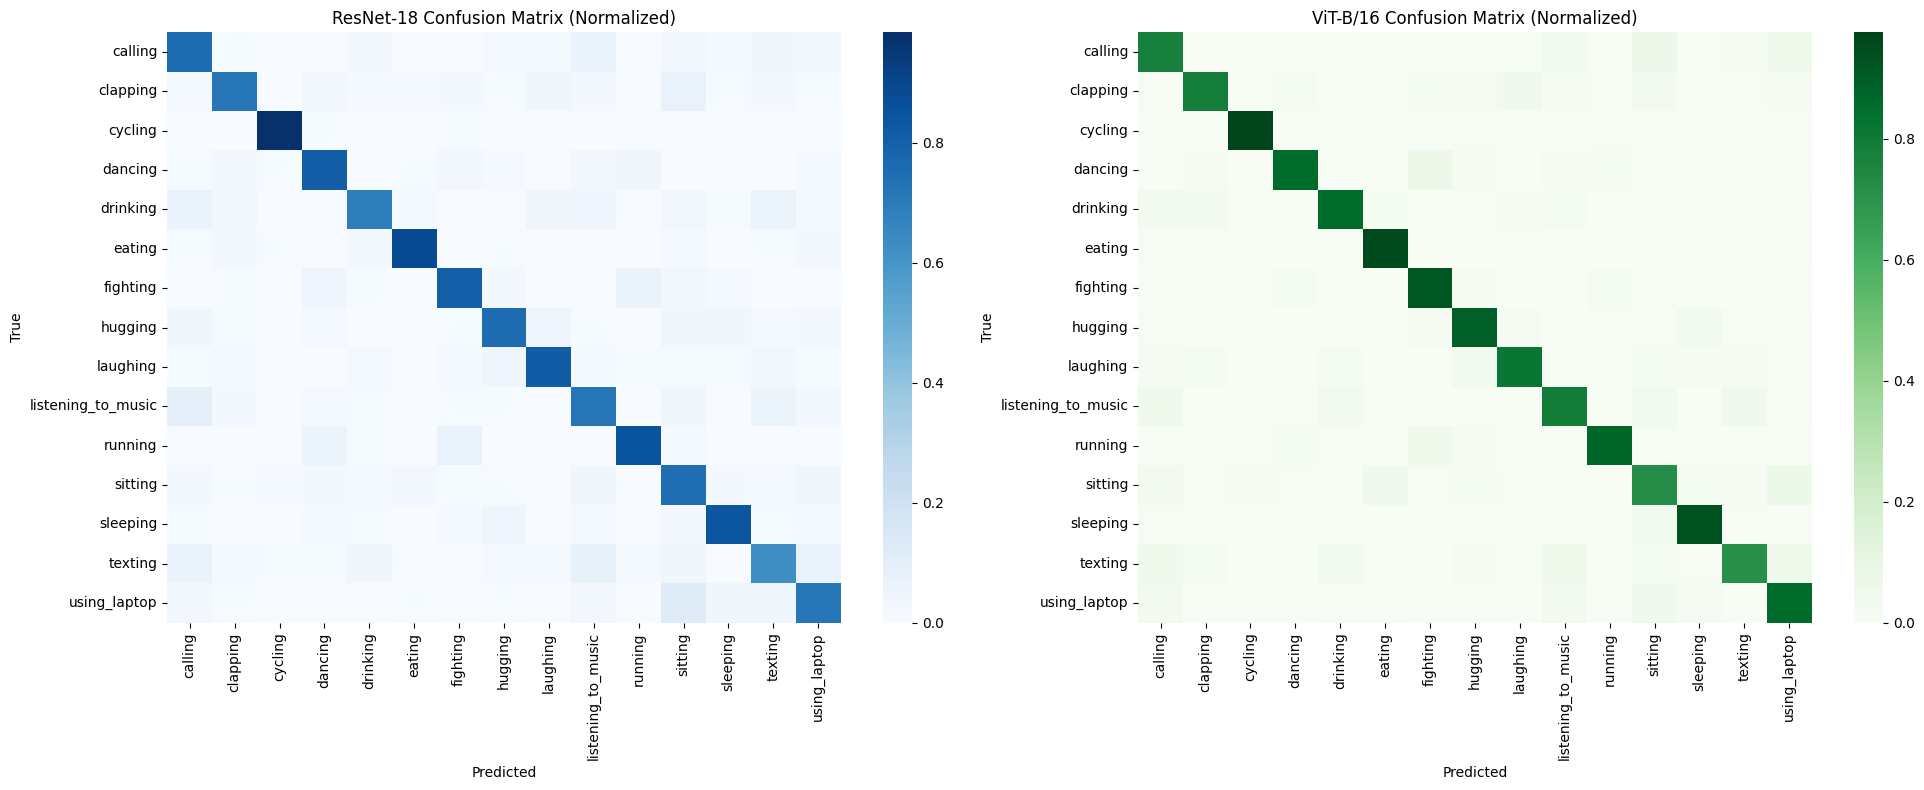

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paths to  CSV confusion matrices
resnet_csv = "logs/resnet18_confusion_matrix.csv"
vit_csv    = "logs/vit_b16_confusion_matrix.csv"

# Load
resnet_cm = pd.read_csv(r"C:\Users\umaim\Downloads\archive\Structured\resnet_vit_har\logs\resnet18_test_metrics_confusion_matrix.csv", index_col=0)
vit_cm    = pd.read_csv(r"C:\Users\umaim\Downloads\archive\Structured\resnet_vit_har\logs\vit_b16_test_metrics_confusion_matrix.csv", index_col=0)

# Normalize by row (per-class %)
resnet_cm_norm = resnet_cm.div(resnet_cm.sum(axis=1), axis=0)
vit_cm_norm    = vit_cm.div(vit_cm.sum(axis=1), axis=0)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(resnet_cm_norm, annot=False, cmap="Blues", xticklabels=resnet_cm.columns, yticklabels=resnet_cm.index, ax=axes[0])
axes[0].set_title("ResNet-18 Confusion Matrix (Normalized)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(vit_cm_norm, annot=False, cmap="Greens", xticklabels=vit_cm.columns, yticklabels=vit_cm.index, ax=axes[1])
axes[1].set_title("ViT-B/16 Confusion Matrix (Normalized)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()


In [ ]:
# FAILURE-CASE MINER: saves top-N misclassified images with overlays + a CSV manifest.
# - Picks "most interesting" failures by highest wrong-pred confidence (can switch to lowest confidence of GT if desired).

import os, csv, shutil, math
from pathlib import Path
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import cv2

DATA_ROOT   = r"C:\Users\umaim\Downloads\archive\Structured"     # parent folder that contains data/train and data/test
CHECKPOINT  = r"artifacts\vit_b16\vit_b16_20250823_232537\best.pt" # path to your best.pt (ResNet or ViT)
SPLIT       = "test"                                              # 'test' or 'val' if you want
TOP_N       = 60                                                  # how many failure samples to save
OUT_DIR     = Path("failure_cases")                               # output folder for failures
IMG_SIZE    = 224
BATCH_SIZE  = 128
NUM_WORKERS = 2

import sys
sys.path.append("src")
from models import build_model

device = "cuda" if torch.cuda.is_available() else "cpu"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Load checkpoint (keeps your saved args/classes)
ckpt = torch.load(CHECKPOINT, map_location=device)
classes = ckpt["classes"]
model_name = ckpt["args"]["model"]
dropout = ckpt.get("args", {}).get("dropout", 0.0)

# Rebuild model with the same head shape (handles dropout case)
model = build_model(model_name, num_classes=len(classes), pretrained=False, dropout=dropout).to(device)
model.load_state_dict(ckpt["state_dict"])
model.eval()

# Build dataset/dataloader (matches eval transforms)
split_dir = Path(DATA_ROOT) / "data" / SPLIT
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
ds = datasets.ImageFolder(str(split_dir), transform=tfm)
dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Inverse normalization for overlays
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

# Run inference & collect failures
failures = []  # list of dicts: {idx, path, gt_idx, pred_idx, pred_conf, gt_label, pred_label}
with torch.no_grad():
    offset = 0
    for images, targets in dl:
        images = images.to(device)
        logits = model(images)
        probs = F.softmax(logits, dim=1)
        conf, pred = torch.max(probs, dim=1)

        for i in range(images.size(0)):
            gt = int(targets[i].item())
            pr = int(pred[i].item())
            if pr != gt:
                failures.append({
                    "idx": offset + i,
                    "path": ds.samples[offset + i][0],
                    "gt_idx": gt,
                    "pred_idx": pr,
                    "pred_conf": float(conf[i].item()),
                    "gt_label": classes[gt],
                    "pred_label": classes[pr],
                })
        offset += images.size(0)

print(f"Total failures found: {len(failures)}")

# Rank failures by highest wrong-pred confidence (most egregious)
failures_sorted = sorted(failures, key=lambda d: d["pred_conf"], reverse=True)[:TOP_N]

# Helper: save overlayed image
def save_overlay(pil_img, out_path, text_lines, bar_h=28):
    # Convert to BGR for cv2
    arr = np.array(pil_img.convert("RGB"))
    h, w = arr.shape[:2]
    frame = cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)

    # Draw header bar
    cv2.rectangle(frame, (0, 0), (w, bar_h + 6), (0, 0, 0), -1)
    y = 20
    for t in text_lines:
        cv2.putText(frame, t, (8, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        y += 20

    cv2.imwrite(str(out_path), frame)

# Manifest CSV
csv_path = OUT_DIR / "failures_manifest.csv"
with open(csv_path, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["idx","image_path","gt_label","pred_label","pred_conf","saved_png"])
    # Iterate and save
    for k, item in enumerate(failures_sorted):
        # Load the original image again (un-normalized)
        orig = Image.open(item["path"]).convert("RGB").resize((IMG_SIZE, IMG_SIZE))

        # Filename with info
        fname = f"fail_{k:03d}_{item['gt_label']}_pred-{item['pred_label']}_{item['pred_conf']:.2f}.png"
        out_png = OUT_DIR / fname

        # Overlay lines
        txt = [
            f"GT: {item['gt_label']}",
            f"Pred: {item['pred_label']} ({item['pred_conf']:.2f})"
        ]
        save_overlay(orig, out_png, txt)

        w.writerow([item["idx"], item["path"], item["gt_label"], item["pred_label"], f"{item['pred_conf']:.4f}", str(out_png)])

print(f"Saved top-{len(failures_sorted)} failure cases to: {OUT_DIR}")
print(f"CSV manifest: {csv_path}")



C:\Users\umaim\AppData\Local\Temp\ipykernel_14940\2175404.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CHECKPOINT, map_location=device)


Total failures found: 286
Saved top-60 failure cases to: failure_cases
CSV manifest: failure_cases\failures_manifest.csv


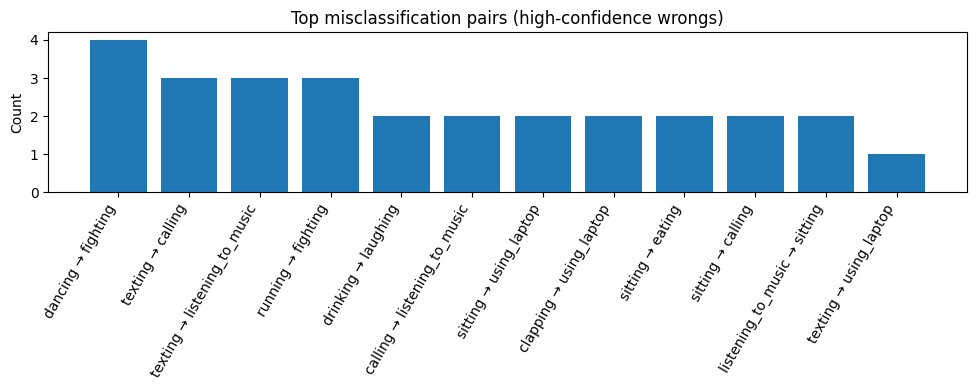

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("failure_cases/failures_manifest.csv")
pair = (df["gt_label"] + " → " + df["pred_label"])
counts = pair.value_counts().head(12)

plt.figure(figsize=(10,4))
plt.bar(range(len(counts)), counts.values)
plt.xticks(range(len(counts)), counts.index, rotation=60, ha="right")
plt.ylabel("Count")
plt.title("Top misclassification pairs (high-confidence wrongs)")
plt.tight_layout()
plt.show()


In [5]:
from PIL import Image, ImageDraw, ImageFont
import pandas as pd, os, math

df = pd.read_csv(r"C:\Users\umaim\Downloads\archive\Structured\resnet_vit_har\failure_cases\failures_manifest.csv").head(20)  # top 20
W, H = 224, 224
cols, rows = 5, math.ceil(len(df)/5)
pad = 8
grid = Image.new("RGB", (cols*(W+pad)+pad, rows*(H+pad)+pad), (255,255,255))
draw = ImageDraw.Draw(grid)

for i,(idx,row) in enumerate(df.iterrows()):
    r, c = divmod(i, cols)
    x, y = pad + c*(W+pad), pad + r*(H+pad)
    img = Image.open(row["saved_png"]).convert("RGB").resize((W,H))
    grid.paste(img, (x,y))
    # caption strip
    caption = f"GT:{row['gt_label']}  Pred:{row['pred_label']} ({float(row['pred_conf']):.2f})"
    draw.rectangle((x, y+H-22, x+W, y+H), fill=(0,0,0))
    draw.text((x+4, y+H-20), caption, fill=(0,255,0))
    
out_path = "failure_cases/top20_failures_grid.png"
grid.save(out_path)
print("Saved", out_path)



Saved failure_cases/top20_failures_grid.png


[info] vit best:  artifacts\vit_b16\vit_b16_20250823_232537\best.pt
[info] res best:  artifacts\resnet18\resnet18_20250823_231603\best.pt


C:\Users\umaim\AppData\Local\Temp\ipykernel_14940\1704958195.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=device)


[info] total failures: 286  (vit_b16_20250823_232537)
[ok] wrote: failure_cases_vit\failures_manifest.csv
[ok] wrote: failure_cases_vit\top20_failures_grid.png


C:\Users\umaim\AppData\Local\Temp\ipykernel_14940\1704958195.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=device)


[info] total failures: 415  (resnet18_20250823_231603)
[ok] wrote: failure_cases_resnet\failures_manifest.csv
[ok] wrote: failure_cases_resnet\top20_failures_grid.png

=== Pairs improved most by ViT (negative delta) ===
using_laptop → sitting         -4.0
fighting → running             -3.0
texting → using_laptop         -2.0
calling → listening_to_music   -1.0
listening_to_music → texting   -1.0
texting → sitting              -1.0
hugging → laughing             -1.0
sitting → sleeping             -1.0
listening_to_music → calling    0.0
listening_to_music → eating     0.0
listening_to_music → sitting    0.0
running → cycling               0.0
Name: count, dtype: float64

=== Pairs worse in ViT (positive delta) ===
eating → drinking                0.0
fighting → dancing               0.0
hugging → sitting                0.0
hugging → sleeping               0.0
laughing → calling               0.0
laughing → clapping              0.0
drinking → clapping              0.0
laughing → liste

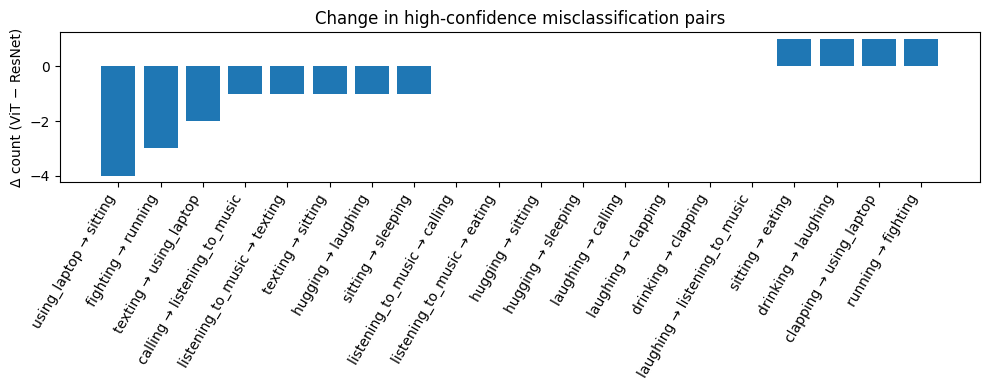


Artifacts created:
 - failure_cases_vit\failures_manifest.csv
 - failure_cases_vit\top20_failures_grid.png
 - failure_cases_resnet\failures_manifest.csv
 - failure_cases_resnet\top20_failures_grid.png


In [ ]:
#mine failures for ResNet18 + ViT-B/16, save grids, and compare deltas.

import os, math, csv
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

DATA_ROOT = r"C:\Users\umaim\Downloads\archive\Structured"   # parent of data/train and data/test
SPLIT = "test"                                               # 'test' or 'val'
IMG_SIZE = 224
BATCH_SIZE = 128
NUM_WORKERS = 2
TOP_N = 60                                                   # how many failures to save & visualize
OUT_VIT = Path("failure_cases_vit")
OUT_RES = Path("failure_cases_resnet")

import sys
sys.path.append("src")
from models import build_model

device = "cuda" if torch.cuda.is_available() else "cpu"

def find_latest_best(pt_dir: Path) -> Path:
    cands = sorted(pt_dir.rglob("best.pt"), key=lambda p: p.stat().st_mtime, reverse=True)
    if not cands:
        raise FileNotFoundError(f"No best.pt under {pt_dir}")
    return cands[0]

ckpt_vit  = find_latest_best(Path("artifacts/vit_b16"))
ckpt_res  = find_latest_best(Path("artifacts/resnet18"))
print(f"[info] vit best:  {ckpt_vit}")
print(f"[info] res best:  {ckpt_res}")

# shared dataset/loader
split_dir = Path(DATA_ROOT) / "data" / SPLIT
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
ds = datasets.ImageFolder(str(split_dir), transform=tfm)
dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

def run_failures(checkpoint_path: Path, out_dir: Path, top_n: int):
    out_dir.mkdir(parents=True, exist_ok=True)
    ckpt = torch.load(checkpoint_path, map_location=device)
    classes = ckpt["classes"]
    model_name = ckpt["args"]["model"]
    dropout = ckpt.get("args", {}).get("dropout", 0.0)

    model = build_model(model_name, num_classes=len(classes), pretrained=False, dropout=dropout).to(device)
    model.load_state_dict(ckpt["state_dict"])
    model.eval()

    failures = []
    with torch.no_grad():
        offset = 0
        for x, y in dl:
            x = x.to(device)
            logits = model(x)
            probs = F.softmax(logits, dim=1)
            conf, pred = torch.max(probs, dim=1)
            for i in range(x.size(0)):
                gt = int(y[i].item())
                pr = int(pred[i].item())
                if pr != gt:
                    failures.append({
                        "idx": offset + i,
                        "image_path": ds.samples[offset + i][0],
                        "gt_label": classes[gt],
                        "pred_label": classes[pr],
                        "pred_conf": float(conf[i].item()),
                    })
            offset += x.size(0)

    print(f"[info] total failures: {len(failures)}  ({checkpoint_path.parent.name})")
    failures_sorted = sorted(failures, key=lambda d: d["pred_conf"], reverse=True)[:top_n]

    # overlay helper (using PIL only)
    def save_overlay(png_in: Path, out_png: Path, gt: str, pred: str, conf: float):
        img = Image.open(png_in).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
        draw = ImageDraw.Draw(img)
        strip_h = 26
        draw.rectangle([(0,0),(IMG_SIZE,strip_h)], fill=(0,0,0))
        text = f"GT: {gt}   Pred: {pred} ({conf:.2f})"
        draw.text((6,6), text, fill=(0,255,0))
        img.save(out_png)

    # manifest csv + top-N overlays
    csv_path = out_dir / "failures_manifest.csv"
    with open(csv_path, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["idx","image_path","gt_label","pred_label","pred_conf","saved_png"])
        for k, item in enumerate(failures_sorted):
            out_png = out_dir / f"fail_{k:03d}_{item['gt_label']}_pred-{item['pred_label']}_{item['pred_conf']:.2f}.png"
            save_overlay(Path(item["image_path"]), out_png, item["gt_label"], item["pred_label"], item["pred_conf"])
            w.writerow([item["idx"], item["image_path"], item["gt_label"], item["pred_label"], f"{item['pred_conf']:.4f}", str(out_png)])

    # create a grid image of the first 20 failures
    df = pd.read_csv(csv_path).head(20)
    W, H = IMG_SIZE, IMG_SIZE
    cols, rows = 5, math.ceil(len(df)/5)
    pad = 8
    grid = Image.new("RGB", (cols*(W+pad)+pad, rows*(H+pad)+pad), (255,255,255))
    for i, (_, row) in enumerate(df.iterrows()):
        r, c = divmod(i, cols)
        x, y = pad + c*(W+pad), pad + r*(H+pad)
        tile = Image.open(row["saved_png"]).convert("RGB").resize((W,H))
        grid.paste(tile, (x,y))
    grid_path = out_dir / "top20_failures_grid.png"
    grid.save(grid_path)
    print(f"[ok] wrote: {csv_path}")
    print(f"[ok] wrote: {grid_path}")
    return csv_path, grid_path

csv_vit, grid_vit = run_failures(ckpt_vit, OUT_VIT, TOP_N)
csv_res, grid_res = run_failures(ckpt_res, OUT_RES, TOP_N)

# ---- Compare pair deltas (ViT - ResNet) ----
v = pd.read_csv(csv_vit)
r = pd.read_csv(csv_res)
v_pairs = (v["gt_label"] + " → " + v["pred_label"]).value_counts()
r_pairs = (r["gt_label"] + " → " + r["pred_label"]).value_counts()
delta = (v_pairs - r_pairs).fillna(0).sort_values()  # negative = ViT had fewer high-conf errors

print("\n=== Pairs improved most by ViT (negative delta) ===")
print(delta.head(12))
print("\n=== Pairs worse in ViT (positive delta) ===")
print(delta.tail(12))

# Simple bar of top improvements/worsenings
topk = 10
plt.figure(figsize=(10,4))
subset = pd.concat([delta.head(topk), delta.tail(topk)])
plt.bar(range(len(subset)), subset.values)
plt.xticks(range(len(subset)), subset.index, rotation=60, ha="right")
plt.ylabel("Δ count (ViT − ResNet)")
plt.title("Change in high-confidence misclassification pairs")
plt.tight_layout()
plt.show()

print("\nArtifacts created:")
print(f" - {csv_vit}")
print(f" - {grid_vit}")
print(f" - {csv_res}")
print(f" - {grid_res}")
